In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda is available


## Experiment setup

In [2]:
import wandb 
from datetime import datetime
import pandas as pd

experiment_log = []

# function version
def save_experiment(outfolder="./runs"):
    run_name = "run-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    os.makedirs(outfolder, exist_ok=True)
    os.makedirs(os.path.join(outfolder, run_name), exist_ok=True)
    keys = experiment_log[0].keys()
    for key in keys:
        np.save(os.path.join(outfolder, run_name, f"{key}.npy"), np.array([log.get(key, None) for log in experiment_log]))

    df = pd.DataFrame(experiment_log)
    df.to_csv(os.path.join(outfolder, run_name, "log.csv"), index=False)

    print(f"Experiment saved to {os.path.join(outfolder, run_name)}")

def init_experiment(config):
    wandb.init(
        project="rug-drl-catchgame",
        config=config,
    )

def terminate_experiment(save=True):
    wandb.finish()
    if save:
        save_experiment()

def log(data):
    experiment_log.append(data)
    print("; ".join([f"{k}: {v}" for k, v in data.items()]))
    wandb.log(data)



In [3]:
from modules.dqn.network import QNetworkConv
from world import CatchEnv

n_actions = 3
n_episodes = 1000
batch_size = 512

CATCH_ENV_NUM_STATES = 4
CATCH_ENV_WORLD_SIZE = (84, 84)
CATCH_ENV_POSSIBLE_ACTIONS = [0, 1, 2]

spatial_size = CATCH_ENV_WORLD_SIZE

dqn = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES, 
    spatial_size=spatial_size, 
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)
dqn_target = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES,
    spatial_size=spatial_size,
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)

In [4]:
env = CatchEnv()
env.reset_random()
next_state, reward, done = env.step(action=1)
next_state.shape, reward, done

((84, 84, 4), 0, False)

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(spatial_size),
    lambda x: x.unsqueeze(0),
    lambda x: x.type(torch.float32),
])

transforms(next_state).shape

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 4, 84, 84])

In [6]:
optimizer = optim.Adam(dqn.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

num_episodes = 1000
epsilon = 0.8
gamma = 0.9
epsilon_decay = 0.99


In [7]:
import random
from collections import deque

# Define a replay buffer class to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done_flags = zip(*batch)
        return states, actions, rewards, next_states, done_flags

# Initialize the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

def evaulate(epsilon=0.0, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset_random()
        state = transforms(state)
        done = False
        episode_reward = 0
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
            else:
                q_values = dqn(state.to(device))
                action = q_values.argmax().item()
            next_state, reward, done = env.step(action)
            next_state = transforms(next_state)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    return np.mean(rewards)

def sample_epsilon_exponential_decay(min_epsilon=0.01, max_epsilon=0.9, t=0.0, decay_rate=0.5):
    I = max_epsilon
    E = min_epsilon
    s = 10 * decay_rate
    theta = (np.exp(-s*t) -1) / (1 - np.exp(-s)) + 1
    return (I - E) * theta + E

### Training

In [8]:

init_experiment(config={
    "num_episodes": num_episodes,
    "batch_size": batch_size,
    "gamma": gamma,
    "epsilon_decay": epsilon_decay,
    "spatial_size": spatial_size,
})

################ TRAINING ################

best_performance = evaulate(epsilon=0.0, num_episodes=10)
log({"episode": 0, "epsilon": 0.0, "reward": best_performance})

for episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset_random()
    state = transforms(state)
    done = False
    
    done_i = 0

    while not done:
        # Choose an action using an epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
        else:
            q_values = dqn(state.to(device))
            action = q_values.argmax().item()
        
        # Take the action and observe the next state and reward
        next_state, reward, done = env.step(action)
        next_state = transforms(next_state)
        
        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer.buffer) > batch_size:
            states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
            # (batch, 4, 84, 84)
            # [(1, 4, 84, 84), ... ] -> (batch, 4, 84, 84)
            
            states = torch.cat(states).to(device)
            actions = torch.Tensor(actions).type(dtype=torch.int64).to(device)
            rewards = torch.Tensor(rewards).to(device)
            next_states = torch.cat(next_states).to(device)
            done_flags = torch.Tensor(done_flags).to(device)

            # Compute the target Q-values using the DDQN algorithm
            q_values = dqn(states)
            max_actions = q_values.argmax(dim=-1)
            
            with torch.no_grad():
                q_values_target = dqn_target(next_states)
            q_values_target = q_values_target.gather(1, max_actions.unsqueeze(-1)).squeeze(-1)
            q_values_target = rewards + gamma * q_values_target * (1 - done_flags)
            
            # Compute the current Q-values and the loss
            current_q_values = q_values.gather(1, torch.Tensor(actions).unsqueeze(-1)).squeeze(-1)
            loss = criterion(current_q_values, q_values_target.detach())
            
            # Update the DQN network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the target network
            if done_i % 10 == 0:
                dqn_target.load_state_dict(dqn.state_dict())
            done_i += 1
        
        # Update the state
        state = next_state

    # Evaluate the policy and save the results
    if episode % 10 == 0:
        mean_reward = evaulate(epsilon=0.0, num_episodes=10)
        epsilon = sample_epsilon_exponential_decay(t=mean_reward, decay_rate=0.01, max_epsilon=1)
        if mean_reward >= best_performance:
            best_performance = mean_reward
            torch.save(dqn.state_dict(), "models/dqn_best.pt")
        log({"episode": episode, "mean_reward": mean_reward, "epsilon": epsilon})

################ TRAINING END ################

terminate_experiment()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


episode: 0; epsilon: 0.0; reward: 0.3


  0%|          | 1/1000 [00:00<02:51,  5.84it/s]

episode: 0; mean_reward: 0.3; epsilon: 0.3817216991062283


  2%|▏         | 16/1000 [00:00<00:28, 35.13it/s]

episode: 10; mean_reward: 0.2; epsilon: 0.5299195944432384


  3%|▎         | 30/1000 [00:00<00:22, 44.05it/s]

episode: 20; mean_reward: 0.1; epsilon: 0.7299658287281285


  4%|▎         | 36/1000 [00:01<00:26, 36.10it/s]

episode: 30; mean_reward: 0.2; epsilon: 0.5299195944432384


  4%|▍         | 41/1000 [00:01<00:29, 33.03it/s]

episode: 40; mean_reward: 0.2; epsilon: 0.5299195944432384


  5%|▌         | 51/1000 [00:03<02:27,  6.43it/s]

episode: 50; mean_reward: 0.3; epsilon: 0.3817216991062283


  6%|▌         | 61/1000 [00:08<06:13,  2.52it/s]

episode: 60; mean_reward: 0.3; epsilon: 0.3817216991062283


  7%|▋         | 71/1000 [00:13<08:24,  1.84it/s]

episode: 70; mean_reward: 0.4; epsilon: 0.27193399797388856


  8%|▊         | 81/1000 [00:19<08:20,  1.84it/s]

episode: 80; mean_reward: 0.3; epsilon: 0.3817216991062283


  9%|▉         | 91/1000 [00:24<08:16,  1.83it/s]

episode: 90; mean_reward: 0.2; epsilon: 0.5299195944432384


 10%|█         | 101/1000 [00:29<07:53,  1.90it/s]

episode: 100; mean_reward: 0.4; epsilon: 0.27193399797388856


 11%|█         | 111/1000 [00:34<08:20,  1.78it/s]

episode: 110; mean_reward: 0.5; epsilon: 0.19060126856829268


 12%|█▏        | 121/1000 [00:40<08:16,  1.77it/s]

episode: 120; mean_reward: 0.2; epsilon: 0.5299195944432384


 13%|█▎        | 131/1000 [00:45<07:41,  1.88it/s]

episode: 130; mean_reward: 0.2; epsilon: 0.5299195944432384


 14%|█▍        | 141/1000 [00:50<07:46,  1.84it/s]

episode: 140; mean_reward: 0.2; epsilon: 0.5299195944432384


 15%|█▌        | 151/1000 [00:55<07:22,  1.92it/s]

episode: 150; mean_reward: 0.3; epsilon: 0.3817216991062283


 16%|█▌        | 161/1000 [01:00<07:41,  1.82it/s]

episode: 160; mean_reward: 0.1; epsilon: 0.7299658287281285


 17%|█▋        | 171/1000 [01:05<07:09,  1.93it/s]

episode: 170; mean_reward: 0.2; epsilon: 0.5299195944432384


 18%|█▊        | 181/1000 [01:10<07:17,  1.87it/s]

episode: 180; mean_reward: 0.5; epsilon: 0.19060126856829268


 19%|█▉        | 191/1000 [01:15<07:54,  1.71it/s]

episode: 190; mean_reward: 0.7; epsilon: 0.08571215239377379


 20%|██        | 201/1000 [01:21<07:44,  1.72it/s]

episode: 200; mean_reward: 0.5; epsilon: 0.19060126856829268


 21%|██        | 211/1000 [01:26<07:26,  1.77it/s]

episode: 210; mean_reward: 0.3; epsilon: 0.3817216991062283


 22%|██▏       | 221/1000 [01:32<07:21,  1.76it/s]

episode: 220; mean_reward: 0.4; epsilon: 0.27193399797388856


 23%|██▎       | 231/1000 [01:37<07:11,  1.78it/s]

episode: 230; mean_reward: 0.5; epsilon: 0.19060126856829268


 24%|██▍       | 241/1000 [01:43<07:46,  1.63it/s]

episode: 240; mean_reward: 0.4; epsilon: 0.27193399797388856


 25%|██▌       | 251/1000 [01:48<07:55,  1.57it/s]

episode: 250; mean_reward: 0.3; epsilon: 0.3817216991062283


 26%|██▌       | 261/1000 [01:54<07:10,  1.71it/s]

episode: 260; mean_reward: 0.5; epsilon: 0.19060126856829268


 27%|██▋       | 271/1000 [02:00<07:29,  1.62it/s]

episode: 270; mean_reward: 0.1; epsilon: 0.7299658287281285


 28%|██▊       | 281/1000 [02:05<06:37,  1.81it/s]

episode: 280; mean_reward: 0.4; epsilon: 0.27193399797388856


 29%|██▉       | 291/1000 [02:10<07:03,  1.67it/s]

episode: 290; mean_reward: 0.4; epsilon: 0.27193399797388856


 30%|███       | 301/1000 [02:16<06:39,  1.75it/s]

episode: 300; mean_reward: 0.7; epsilon: 0.08571215239377379


 31%|███       | 311/1000 [02:22<06:44,  1.71it/s]

episode: 310; mean_reward: 0.4; epsilon: 0.27193399797388856


 32%|███▏      | 321/1000 [02:27<06:31,  1.73it/s]

episode: 320; mean_reward: 0.5; epsilon: 0.19060126856829268


 33%|███▎      | 331/1000 [02:32<06:10,  1.80it/s]

episode: 330; mean_reward: 0.2; epsilon: 0.5299195944432384


 34%|███▍      | 341/1000 [02:37<05:50,  1.88it/s]

episode: 340; mean_reward: 0.5; epsilon: 0.19060126856829268


 35%|███▌      | 351/1000 [02:43<06:13,  1.74it/s]

episode: 350; mean_reward: 0.5; epsilon: 0.19060126856829268


 36%|███▌      | 361/1000 [02:48<06:11,  1.72it/s]

episode: 360; mean_reward: 0.7; epsilon: 0.08571215239377379


 37%|███▋      | 371/1000 [02:54<06:07,  1.71it/s]

episode: 370; mean_reward: 0.6; epsilon: 0.13034850068685155


 38%|███▊      | 381/1000 [02:59<06:15,  1.65it/s]

episode: 380; mean_reward: 0.5; epsilon: 0.19060126856829268


 39%|███▉      | 391/1000 [03:05<05:52,  1.73it/s]

episode: 390; mean_reward: 0.7; epsilon: 0.08571215239377379


 40%|████      | 401/1000 [03:10<05:47,  1.72it/s]

episode: 400; mean_reward: 0.5; epsilon: 0.19060126856829268


 41%|████      | 411/1000 [03:16<05:37,  1.74it/s]

episode: 410; mean_reward: 0.2; epsilon: 0.5299195944432384


 42%|████▏     | 421/1000 [03:21<05:17,  1.82it/s]

episode: 420; mean_reward: 0.4; epsilon: 0.27193399797388856


 43%|████▎     | 431/1000 [03:26<05:18,  1.79it/s]

episode: 430; mean_reward: 0.7; epsilon: 0.08571215239377379


 44%|████▍     | 441/1000 [03:32<05:20,  1.74it/s]

episode: 440; mean_reward: 0.7; epsilon: 0.08571215239377379


 45%|████▌     | 451/1000 [03:37<05:17,  1.73it/s]

episode: 450; mean_reward: 0.7; epsilon: 0.08571215239377379


 46%|████▌     | 461/1000 [03:43<05:22,  1.67it/s]

episode: 460; mean_reward: 0.5; epsilon: 0.19060126856829268


 47%|████▋     | 471/1000 [03:49<05:18,  1.66it/s]

episode: 470; mean_reward: 0.5; epsilon: 0.19060126856829268


 48%|████▊     | 481/1000 [03:54<05:11,  1.67it/s]

episode: 480; mean_reward: 0.7; epsilon: 0.08571215239377379


 49%|████▉     | 491/1000 [04:00<05:21,  1.58it/s]

episode: 490; mean_reward: 0.6; epsilon: 0.13034850068685155


 50%|█████     | 501/1000 [04:06<05:02,  1.65it/s]

episode: 500; mean_reward: 1.0; epsilon: 0.01


 51%|█████     | 511/1000 [04:12<05:13,  1.56it/s]

episode: 510; mean_reward: 0.6; epsilon: 0.13034850068685155


 52%|█████▏    | 521/1000 [04:18<04:51,  1.65it/s]

episode: 520; mean_reward: 0.6; epsilon: 0.13034850068685155


 53%|█████▎    | 531/1000 [04:24<05:01,  1.55it/s]

episode: 530; mean_reward: 0.5; epsilon: 0.19060126856829268


 54%|█████▍    | 541/1000 [04:29<04:22,  1.75it/s]

episode: 540; mean_reward: 0.6; epsilon: 0.13034850068685155


 55%|█████▌    | 551/1000 [04:35<04:21,  1.72it/s]

episode: 550; mean_reward: 0.5; epsilon: 0.19060126856829268


 56%|█████▌    | 561/1000 [04:40<04:09,  1.76it/s]

episode: 560; mean_reward: 0.7; epsilon: 0.08571215239377379


 57%|█████▋    | 571/1000 [04:46<04:12,  1.70it/s]

episode: 570; mean_reward: 0.7; epsilon: 0.08571215239377379


 58%|█████▊    | 581/1000 [04:51<04:07,  1.69it/s]

episode: 580; mean_reward: 0.6; epsilon: 0.13034850068685155


 59%|█████▉    | 591/1000 [04:57<03:49,  1.78it/s]

episode: 590; mean_reward: 0.6; epsilon: 0.13034850068685155


 60%|██████    | 601/1000 [05:02<03:46,  1.76it/s]

episode: 600; mean_reward: 0.6; epsilon: 0.13034850068685155


 61%|██████    | 611/1000 [05:08<03:50,  1.69it/s]

episode: 610; mean_reward: 0.6; epsilon: 0.13034850068685155


 62%|██████▏   | 621/1000 [05:13<03:36,  1.75it/s]

episode: 620; mean_reward: 0.9; epsilon: 0.028147784937579468


 63%|██████▎   | 631/1000 [05:19<03:33,  1.73it/s]

episode: 630; mean_reward: 0.6; epsilon: 0.13034850068685155


 64%|██████▍   | 641/1000 [05:24<03:24,  1.75it/s]

episode: 640; mean_reward: 0.8; epsilon: 0.05264473227356636


 65%|██████▌   | 651/1000 [05:30<03:22,  1.72it/s]

episode: 650; mean_reward: 0.5; epsilon: 0.19060126856829268


 66%|██████▌   | 661/1000 [05:35<03:14,  1.74it/s]

episode: 660; mean_reward: 0.8; epsilon: 0.05264473227356636


 67%|██████▋   | 671/1000 [05:41<03:07,  1.75it/s]

episode: 670; mean_reward: 0.4; epsilon: 0.27193399797388856


 68%|██████▊   | 681/1000 [05:46<03:11,  1.67it/s]

episode: 680; mean_reward: 0.6; epsilon: 0.13034850068685155


 69%|██████▉   | 691/1000 [05:52<03:03,  1.68it/s]

episode: 690; mean_reward: 0.7; epsilon: 0.08571215239377379


 70%|███████   | 701/1000 [05:58<03:08,  1.59it/s]

episode: 700; mean_reward: 0.8; epsilon: 0.05264473227356636


 71%|███████   | 711/1000 [06:03<02:57,  1.62it/s]

episode: 710; mean_reward: 0.8; epsilon: 0.05264473227356636


 72%|███████▏  | 721/1000 [06:09<02:56,  1.58it/s]

episode: 720; mean_reward: 0.9; epsilon: 0.028147784937579468


 73%|███████▎  | 731/1000 [06:15<02:46,  1.61it/s]

episode: 730; mean_reward: 0.6; epsilon: 0.13034850068685155


 74%|███████▍  | 741/1000 [06:21<02:39,  1.62it/s]

episode: 740; mean_reward: 0.9; epsilon: 0.028147784937579468


 75%|███████▌  | 751/1000 [06:27<02:36,  1.59it/s]

episode: 750; mean_reward: 0.6; epsilon: 0.13034850068685155


 76%|███████▌  | 761/1000 [06:33<02:27,  1.62it/s]

episode: 760; mean_reward: 1.0; epsilon: 0.01


 77%|███████▋  | 771/1000 [06:39<02:24,  1.59it/s]

episode: 770; mean_reward: 0.7; epsilon: 0.08571215239377379


 78%|███████▊  | 781/1000 [06:44<02:16,  1.60it/s]

episode: 780; mean_reward: 0.7; epsilon: 0.08571215239377379


 79%|███████▉  | 791/1000 [06:50<02:07,  1.64it/s]

episode: 790; mean_reward: 0.6; epsilon: 0.13034850068685155


 80%|████████  | 801/1000 [06:56<02:00,  1.65it/s]

episode: 800; mean_reward: 0.8; epsilon: 0.05264473227356636


 81%|████████  | 811/1000 [07:02<01:55,  1.64it/s]

episode: 810; mean_reward: 0.7; epsilon: 0.08571215239377379


 82%|████████▏ | 821/1000 [07:08<01:51,  1.61it/s]

episode: 820; mean_reward: 0.5; epsilon: 0.19060126856829268


 83%|████████▎ | 831/1000 [07:14<01:43,  1.63it/s]

episode: 830; mean_reward: 0.7; epsilon: 0.08571215239377379


 84%|████████▍ | 841/1000 [07:19<01:38,  1.62it/s]

episode: 840; mean_reward: 1.0; epsilon: 0.01


 85%|████████▌ | 851/1000 [07:26<01:37,  1.53it/s]

episode: 850; mean_reward: 0.7; epsilon: 0.08571215239377379


 86%|████████▌ | 861/1000 [07:31<01:27,  1.59it/s]

episode: 860; mean_reward: 0.6; epsilon: 0.13034850068685155


 87%|████████▋ | 871/1000 [07:37<01:16,  1.68it/s]

episode: 870; mean_reward: 0.6; epsilon: 0.13034850068685155


 88%|████████▊ | 881/1000 [07:43<01:13,  1.62it/s]

episode: 880; mean_reward: 0.8; epsilon: 0.05264473227356636


 89%|████████▉ | 891/1000 [07:49<01:07,  1.61it/s]

episode: 890; mean_reward: 0.8; epsilon: 0.05264473227356636


 90%|█████████ | 901/1000 [07:55<01:03,  1.57it/s]

episode: 900; mean_reward: 0.8; epsilon: 0.05264473227356636


 91%|█████████ | 911/1000 [08:01<00:54,  1.62it/s]

episode: 910; mean_reward: 1.0; epsilon: 0.01


 92%|█████████▏| 921/1000 [08:07<00:50,  1.58it/s]

episode: 920; mean_reward: 0.7; epsilon: 0.08571215239377379


 93%|█████████▎| 931/1000 [08:13<00:42,  1.61it/s]

episode: 930; mean_reward: 0.7; epsilon: 0.08571215239377379


 94%|█████████▍| 941/1000 [08:19<00:37,  1.58it/s]

episode: 940; mean_reward: 0.9; epsilon: 0.028147784937579468


 95%|█████████▌| 951/1000 [08:25<00:31,  1.58it/s]

episode: 950; mean_reward: 0.9; epsilon: 0.028147784937579468


 96%|█████████▌| 961/1000 [08:31<00:25,  1.55it/s]

episode: 960; mean_reward: 1.0; epsilon: 0.01


 97%|█████████▋| 971/1000 [08:37<00:18,  1.61it/s]

episode: 970; mean_reward: 0.7; epsilon: 0.08571215239377379


 98%|█████████▊| 981/1000 [08:43<00:12,  1.52it/s]

episode: 980; mean_reward: 0.8; epsilon: 0.05264473227356636


 99%|█████████▉| 991/1000 [08:49<00:05,  1.52it/s]

episode: 990; mean_reward: 0.8; epsilon: 0.05264473227356636


100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


episode,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epsilon,▁▆▆▅▆▃▆█▂▄▄█▄▃▃▂▃▄▂▃▁▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂
mean_reward,▃▁▃▃▃▂▃▂▄▃▃▁▆▂▄▄▄▆▆▆█▄▄▅▅▅▆▅▆▅█▆▆▆▅▆█▆█▆
reward,▁
episode,990
epsilon,0.05264
mean_reward,0.8
reward,0.3


Experiment saved to ./runs\run-2023-05-15-10-12-28


In [9]:
# load best 
dqn.load_state_dict(torch.load("models/dqn_best1.0.pt"))

<All keys matched successfully>

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


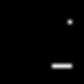

In [10]:
# evluation
env = CatchEnv()
state = env.reset_random()
state = transforms(state)
video = []

while True:
    q_values = dqn(state.to(device))
    action = q_values.argmax().item()
    next_state, reward, done = env.step(action)
    next_state = transforms(next_state)
    state = next_state
    video.append(next_state.squeeze(0))
    if done:
        break

frames = []
video = torch.stack(video)
# shape (k iterations, 4 frames, 84, 84)
# put side to side resulting in (4 * k, 84, 84) without changing the order
video = video.permute(1, 0, 2, 3).reshape(4 * len(video), 84, 84)

# video is of shape (time, 84, 84)
# make a gif and display it
import imageio
from IPython.display import Image

imageio.mimsave("dqn_conv.gif", 255 * video.cpu().numpy())
Image(filename="dqn_conv.gif", format='png')